ACS Plot Tabular data

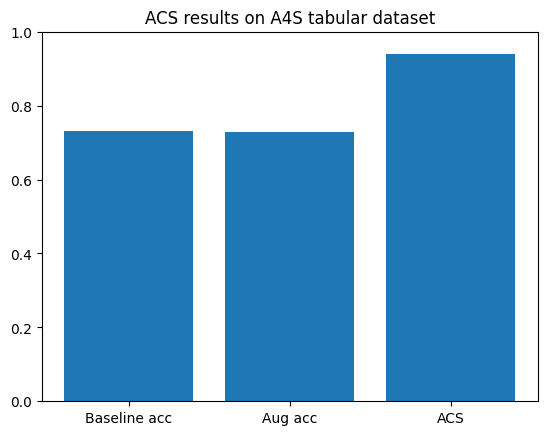

In [34]:
import matplotlib.pyplot as plt

tab_acc_base = 0.731
tab_acc_aug = 0.729
tab_acs = 0.94

plt.figure()
plt.bar(["Baseline acc", "Aug acc", "ACS"], [tab_acc_base, tab_acc_aug, tab_acs])
plt.ylim(0, 1)
plt.title("ACS results on A4S tabular dataset")
plt.show()

Here I applied the Augmentation Consistency Score on the A4S tabular dataset.
MONAI introduces mild numeric perturbations to simulate noise or drift.
The results show that the model is highly stable: ACS is 0.94, and accuracy drop is only 0.002.
This means the tabular model handles small perturbations extremely well.

Tabular data is hard to interpret visually.
So to make the ACS concept easier to understand, I built a second demo on image data.

Imports

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

from torchvision import datasets, transforms
import torchvision.utils as vutils

from monai.transforms import RandGaussianNoise, RandGaussianSmooth, RandAffined

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from IPython.display import display

Loading CIFAR-10 pictures

In [36]:
data_root = "./image_data"
Path(data_root).mkdir(exist_ok=True)

base_transform = transforms.ToTensor()

dataset = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=base_transform,
)

subset = Subset(dataset, list(range(2000)))
loader = DataLoader(subset, batch_size=64, shuffle=False)

print("Loaded:", len(subset), "images")

Loaded: 2000 images


Defining CNN

In [ ]:
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyCNN().to(device)
device

device(type='cuda')

Training

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model.train()
total_loss = 0.0

for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item() * images.size(0)

print("One pass done. Avg loss:", total_loss / len(subset))

One pass done. Avg loss: 2.2531390476226805


MONAI Transformation

In [39]:
from monai.transforms import RandAffine, RandGaussianNoise, RandGaussianSmooth

affine = RandAffine(
    prob=1.0,
    rotate_range=0.1,
    translate_range=(0.05, 0.05),
    scale_range=(0.05, 0.05),
)

noise = RandGaussianNoise(prob=1.0, std=0.05)
blur = RandGaussianSmooth(prob=1.0, sigma_x=(0.5, 1.0))

Applying augmentations to images

In [40]:
def apply_monai(x: torch.Tensor) -> torch.Tensor:
    x_t = affine(x)
    x_t = noise(x_t)
    x_t = blur(x_t)
    return x_t

Compute acs and save flipped images

In [41]:
def top1(logits: torch.Tensor) -> np.ndarray:
    return logits.argmax(dim=1).cpu().numpy()

model.eval()

all_true = []
all_base = []
all_aug = []

flip_dir = Path("image_acs_flips")
flip_dir.mkdir(exist_ok=True)
saved = 0
max_saved = 12

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)

        # augmented images
        images_aug = apply_monai(images)

        logits_base = model(images)
        logits_aug  = model(images_aug)

        y_base = top1(logits_base)
        y_aug  = top1(logits_aug)
        y_true = labels.cpu().numpy()

        all_true.extend(y_true.tolist())
        all_base.extend(y_base.tolist())
        all_aug.extend(y_aug.tolist())

        # save some flip examples
        flips = np.where(y_base != y_aug)[0]
        for i in flips:
            if saved >= max_saved:
                break
            pair = torch.stack([images[i].cpu(), images_aug[i].cpu()], dim=0)
            vutils.save_image(pair, flip_dir / f"flip_{saved}_yt{y_true[i]}_b{y_base[i]}_a{y_aug[i]}.png", nrow=2)
            saved += 1

len(all_true), saved

(2000, 12)

Compute metrics

In [42]:
all_true = np.array(all_true)
all_base = np.array(all_base)
all_aug  = np.array(all_aug)

acc_base = (all_true == all_base).mean()
acc_aug  = (all_true == all_aug).mean()
acs      = (all_base == all_aug).mean()
acc_drop = acc_base - acc_aug

print(f"Baseline accuracy: {acc_base:.4f}")
print(f"Augmented accuracy: {acc_aug:.4f}")
print(f"ACS (consistency): {acs:.4f}")
print(f"Accuracy drop: {acc_drop:.4f}")

Baseline accuracy: 0.3005
Augmented accuracy: 0.2350
ACS (consistency): 0.5640
Accuracy drop: 0.0655


Plot results

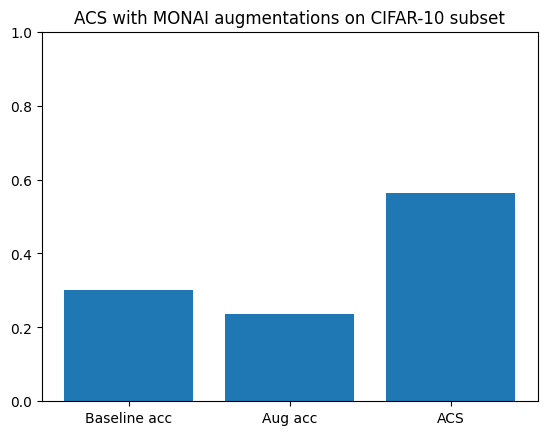

In [43]:
plt.figure()
plt.bar(["Baseline acc", "Aug acc", "ACS"], [acc_base, acc_aug, acs])
plt.ylim(0, 1)
plt.title("ACS with MONAI augmentations on CIFAR-10 subset")
plt.show()

Show flipped images

flip_0_yt1_b8_a1.png


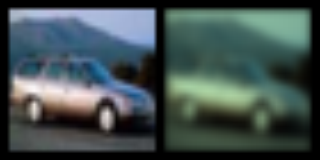

flip_0_yt7_b7_a4.png


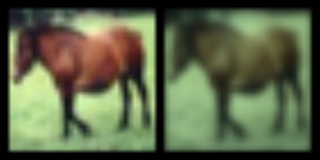

flip_10_yt3_b5_a4.png


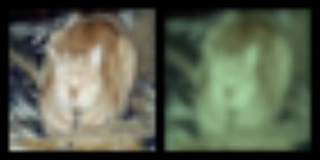

flip_10_yt4_b2_a4.png


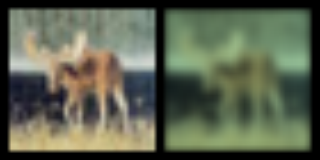

flip_11_yt0_b0_a8.png


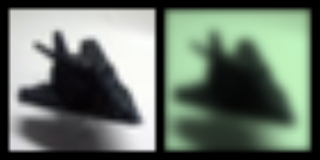

flip_11_yt0_b7_a6.png


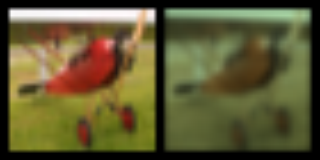

flip_1_yt7_b7_a5.png


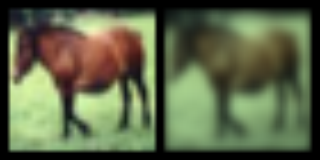

flip_1_yt7_b8_a9.png


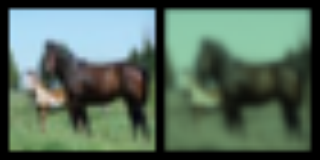

flip_2_yt2_b5_a6.png


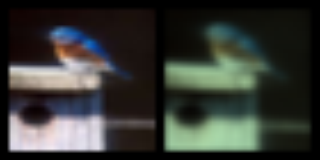

flip_2_yt3_b7_a6.png


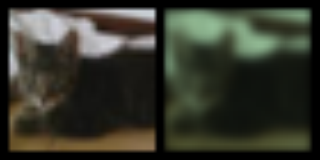

flip_3_yt2_b5_a6.png


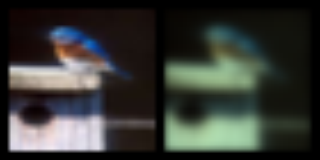

flip_3_yt3_b5_a6.png


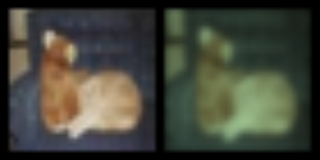

flip_4_yt4_b8_a4.png


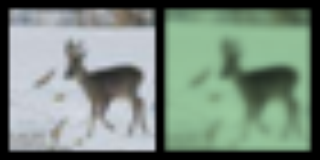

flip_4_yt9_b7_a6.png


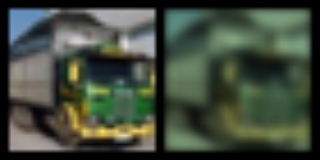

flip_5_yt2_b5_a6.png


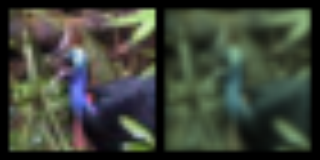

flip_5_yt3_b5_a6.png


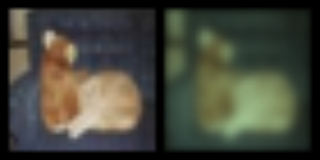

flip_6_yt2_b9_a7.png


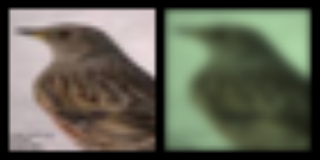

flip_6_yt5_b5_a6.png


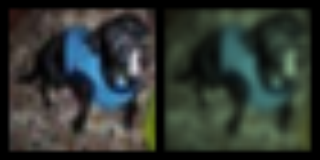

flip_7_yt2_b4_a6.png


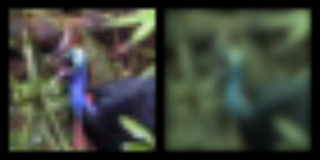

flip_7_yt4_b5_a4.png


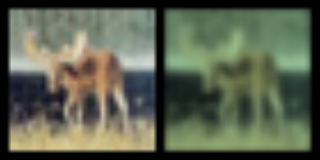

flip_8_yt0_b8_a4.png


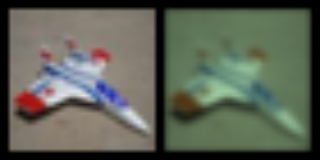

flip_8_yt6_b0_a7.png


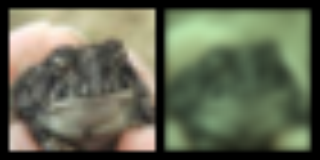

flip_9_yt1_b1_a5.png


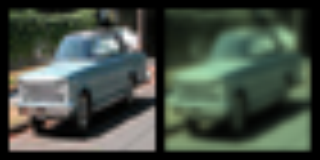

flip_9_yt5_b5_a6.png


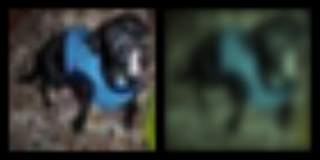

In [44]:
from pathlib import Path
from PIL import Image
from IPython.display import display

src_dir = flip_dir
out_dir = Path("image_acs_flips_big")
out_dir.mkdir(exist_ok=True)

for p in sorted(src_dir.glob("flip_*.png")):
    im = Image.open(p)
    big = im.resize((320, 160), Image.BILINEAR)
    big.save(out_dir / p.name)

    print(p.name)
    display(big)